# Calibração dos Itens do Enem

---



In [67]:
# Instalação de Pacotes
if(!require(tidyverse)){system("tidyverse")}; library(tidyverse)
if(!require(data.table)){system("data.table")}; library(data.table)
if(!require(dtplyr)){system("dtplyr")}; library(dtplyr)
if(!require(mirt)){system("mirt")}; library(mirt)
if(!require(ltm)){system("ltm")}; library(ltm)
if(!require(psych)){system("psych")}; library(psych)
if(!require(archive)){system("archive")}; library(archive)
if(!require(ggpubr)){system("ggpubr")}; library(ggpubr)
if(!require(kableExtra)){system("kableExtra")}; library(kableExtra)
if(!require(IRdisplay)){system("IRdisplay")}; library(IRdisplay)

Carregando pacotes exigidos: IRdisplay

Warning message:
"package 'IRdisplay' was built under R version 4.2.3"




---
## Configurações Iniciais



In [21]:
pasta <- "TRI ENEM/"

ano <- "2022"
area <- "MT"
provas <- c(1075,1076,1077,1078)
tamanho_amostral <- 1000
min_respostas_validas <- 8

## Download e Tratamento dos Microdados


---

### Download dos Dados

In [4]:
# Função de download e descompactação dos microdados
download_enem <- function(ano,dir){
  options(timeout = max(90000, getOption("timeout")))

  link <- paste0("https://download.inep.gov.br/microdados/microdados_enem_",ano,".zip")

  file <- paste0(dir,"ENEM/",ano,"/microdados_enem_",ano,".zip")

  path <- paste0(dir,"ENEM/",ano)
  if(!dir.exists(path)){dir.create(path,recursive = T)}

  if(!file.exists(file)){download.file(url = link, destfile = file)}

  archive_extract(file,dir = path)

}

In [4]:
if(!dir.exists(pasta)){dir.create(pasta,recursive = T)}

download_enem(ano,pasta)

⠙ 116 extracted | 706 MB (331 MB/s) | 2.1s
⠹ 116 extracted | 763 MB (325 MB/s) | 2.3s
⠸ 116 extracted | 818 MB (320 MB/s) | 2.6s
⠼ 116 extracted | 878 MB (318 MB/s) | 2.8s
⠴ 116 extracted | 939 MB (317 MB/s) | 3s  
⠦ 116 extracted | 1000 MB (316 MB/s) | 3.2s
⠧ 116 extracted | 1.1 GB (313 MB/s) | 3.4s 
⠇ 116 extracted | 1.1 GB (310 MB/s) | 3.6s
⠏ 116 extracted | 1.2 GB (307 MB/s) | 3.8s
⠋ 116 extracted | 1.2 GB (304 MB/s) | 4s  
⠙ 116 extracted | 1.3 GB (303 MB/s) | 4.2s
⠹ 116 extracted | 1.3 GB (301 MB/s) | 4.4s
⠸ 116 extracted | 1.4 GB (301 MB/s) | 4.6s
⠼ 116 extracted | 1.4 GB (301 MB/s) | 4.8s
⠴ 116 extracted | 1.5 GB (298 MB/s) | 5s  
⠦ 116 extracted | 1.5 GB (296 MB/s) | 5.2s
⠧ 116 extracted | 1.6 GB (295 MB/s) | 5.4s
⠇ 116 extracted | 1.7 GB (295 MB/s) | 5.6s
⠏ 116 extracted | 1.7 GB (294 MB/s) | 5.8s
⠋ 116 extracted | 1.8 GB (292 MB/s) | 6s  
⠙ 116 extracted | 1.8 GB (290 MB/s) | 6.2s
⠹ 116 extracted | 1.9 GB (288 MB/s) | 6.4s
⠸ 117 extracted | 2.0 GB (295 MB/s) | 6.6s
⠼ 117 ext


---
### Lendo dados e gerando amostra


In [14]:
# Lendo Itens
arquivo_itens <- paste0(pasta,"ENEM/",ano,"/DADOS/ITENS_PROVA_",ano,".csv")

itens <- fread(input=arquivo_itens,integer64='character',encoding = "Latin-1")
itens <- itens  |>
  mutate(area_prova = area) |>
  mutate(CO_POSICAO = case_when(    # A posição original é de 1 a 180, precisa ser de 1 a 45
    area_prova == "LC" ~ CO_POSICAO - 0,   # Primeiro grupo de itens
    area_prova == "CH" ~ CO_POSICAO - 45,  # Segundo grupo de itens
    area_prova == "CN" ~ CO_POSICAO - 90,  # Terceiro grupo de itens
    area_prova == "MT" ~ CO_POSICAO - 135  # Quarto grupo de itens
    )) |>
  filter(CO_PROVA %in% provas) |>
  dplyr::select(CO_POSICAO, CO_ITEM, CO_HABILIDADE,TX_COR,CO_PROVA,TX_GABARITO) |>
  mutate(CO_ITEM = paste0("I_",str_pad(CO_ITEM,width = 6,side = "left",pad = "0"))) |>
  arrange(CO_ITEM) |>
  as.data.frame()


In [15]:
head(itens)

,CO_POSICAO,CO_ITEM,CO_HABILIDADE,TX_COR,CO_PROVA,TX_GABARITO
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>
1,8,I_005961,7,AZUL,1075,D
2,23,I_005961,7,AMARELA,1076,D
3,26,I_005961,7,ROSA,1077,D
4,38,I_005961,7,CINZA,1078,D
5,25,I_008364,6,AZUL,1075,A
6,43,I_008364,6,AMARELA,1076,A


In [22]:
# Lendo Respostas
arquivo_respostas <- paste0(pasta,"ENEM/",ano,"/DADOS/MICRODADOS_ENEM_",ano,".csv")

respostas <- fread(
  arquivo_respostas,
  integer64='character',
  skip=0,  #Ler do inicio
  nrow=-1, #Ler todos os registros
  na.strings = "",
  showProgress = TRUE,
  encoding = "Latin-1")

In [23]:
# Filtrando Presença e Gerando Amostra
set.seed(12345)
amostra <- respostas |>
  lazy_dt() |>
  mutate(respostas_validas = str_count(!!sym(paste0("TX_RESPOSTAS_",area)),"A|B|C|D|E")) |>
  filter(respostas_validas >= min_respostas_validas) |>
  filter(!!sym(paste0("TP_PRESENCA_",area)) == 1) |>
  filter(!!sym(paste0("CO_PROVA_",area)) %in% provas) |>
  sample_n(tamanho_amostral, replace = FALSE) |>       # Gerando amostra
  dplyr::select(NU_INSCRICAO, !!sym(paste0("CO_PROVA_",area)), !!sym(paste0("TX_RESPOSTAS_",area)), !!sym(paste0("TX_GABARITO_",area))) |>
  as.data.frame()

# Removendo base original por questões de memória RAM
rm(respostas)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2885118,154.1,20836767,1112.9,17446052,931.8
Vcells,619484457,4726.3,1507495906,11501.3,1505767233,11488.1


---
### Dicotomizando amostra

In [24]:
# Dicotomizando repostas
dicotomizar <- function(responses,corrections){
  dic_matrix <- (str_split(responses,pattern = "",simplify = T)==str_split(corrections,pattern = "",simplify = T))*1

  apply(dic_matrix, 1, str_flatten)
}

amostra_dicotomizada <- amostra |>
  lazy_dt() |>
  mutate(!!sym(paste0("TX_CORRECAO_",area)) := dicotomizar(!!sym(paste0("TX_RESPOSTAS_",area)),!!sym(paste0("TX_GABARITO_",area)))) |>
  # mutate(TX_CORRECAO_MT = dicotomizar(TX_RESPOSTAS_MT,TX_GABARITO_MT)) |>
  as.data.frame()

amostra_respostas_split <- str_split(amostra_dicotomizada[,paste0("TX_RESPOSTAS_",area)],pattern = "",simplify = T) |> 
  data.frame() |>
  setNames(paste0("r_item_",str_pad( 1:45,2,"left","0")))

amostra_correcao_split <- str_split(amostra_dicotomizada[,paste0("TX_CORRECAO_",area)],pattern = "",simplify = T) |> 
  data.frame() |>
  setNames(paste0("c_item_",str_pad( 1:45,2,"left","0")))

amostra_dicotomizada <- bind_cols(amostra_dicotomizada,amostra_respostas_split,amostra_correcao_split)

In [25]:
head(amostra_dicotomizada)

,NU_INSCRICAO,CO_PROVA_MT,TX_RESPOSTAS_MT,TX_GABARITO_MT,TX_CORRECAO_MT,r_item_01,r_item_02,r_item_03,r_item_04,r_item_05,⋯,c_item_36,c_item_37,c_item_38,c_item_39,c_item_40,c_item_41,c_item_42,c_item_43,c_item_44,c_item_45
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,210058008518,1077,AECCCAECACEAAEDDBBABBACDDBDABEDEBCCEDAEADBDCD,CCCCBXCBABECBEABDDDBDECDBDCAACEECCEBDBAAAEDAE,001100001010010000010011000100010100100100100,A,E,C,C,C,⋯,0,1,0,0,1,0,0,1,0,0
2,210055443843,1076,AAACDCEEECACABCCCDEBCDABEBABBEDBBCDDAEBDECCCC,DBAAACEBEDAECCBECDEECBDCABECBEABDDCCDBDXCBAAC,001001101010000011101000010011010000000000001,A,A,A,C,D,⋯,0,0,0,0,0,0,0,0,0,1
3,210057034159,1078,BAACCCBEECBBECACCDEBEDBACBBEDBAEADEEDCABEBCBE,BEEDAEABDDCEBDBAAAAACXCBCCCBCCDBDEECBDCABEECD,100000000000000000000000100000000010000000000,B,A,A,C,C,⋯,0,0,0,0,0,0,0,0,0,0
4,210055364900,1075,CBDBEDECACDBEDBCBDAEDBBDCADBCCAECDBDCADCBDDAC,ECDABEBDCEECDBDCCCCBCXCBAACDBAAACEBABDDEDAEBE,001000000000000100000000010000101010001000000,C,B,D,B,E,⋯,0,0,0,1,0,0,0,0,0,0
5,210056080871,1077,DEBBAAECACDEBCABDCABDCBBBDBEDDECEBBEDCEDAEEAC,CCCCBXCBABECBEABDDDBDECDBDCAACEECCEBDBAAAEDAE,000000001000101110011000110000100000100011010,D,E,B,B,A,⋯,0,1,0,0,0,1,1,0,1,0
6,210056879478,1076,BBDAEABAEAACDABBAEDACACEDCBBBEABADCACEADBAEDC,DBAAACEBEDAECCBECDEECBDCABECBEABDDCCDBDXCBAAC,010100001010001000001000000011110110000000001,B,B,D,A,E,⋯,0,0,0,0,0,0,0,0,0,1


---
### Ordenando itens da amostra

In [26]:
amostra_resposta_ordenada <- amostra_dicotomizada |> 
  rename(CO_PROVA = !!sym(paste0("CO_PROVA_",area))) |>
  dplyr::select(NU_INSCRICAO,CO_PROVA, r_item_01:r_item_45) |>
  pivot_longer(r_item_01:r_item_45,names_to = "CO_POSICAO",values_to = "RESPOSTA") |>
  lazy_dt() |>
  mutate(CO_POSICAO  = as.numeric(str_remove(CO_POSICAO ,"r_item_"))) |>
  left_join(dplyr::select(itens, CO_PROVA, CO_POSICAO, CO_ITEM), by = c("CO_PROVA","CO_POSICAO")) |>
  dplyr::select(NU_INSCRICAO,CO_ITEM,RESPOSTA) |>
  arrange(NU_INSCRICAO,CO_ITEM)|>
  as.data.frame() |>
  pivot_wider(names_from = "CO_ITEM",values_from = "RESPOSTA")

In [27]:
head(amostra_resposta_ordenada)

NU_INSCRICAO,I_005961,I_008364,I_010322,I_010409,I_010500,I_014797,I_019807,I_028683,I_030053,⋯,I_096315,I_097590,I_111516,I_111738,I_117651,I_117742,I_117820,I_117877,I_117886,I_117973
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
210054479192,E,B,C,D,A,A,A,B,A,⋯,C,E,A,B,B,C,E,C,C,A
210054483969,B,A,A,E,D,A,D,A,C,⋯,A,C,C,.,.,.,.,B,.,A
210054484198,B,E,C,D,D,C,B,A,C,⋯,A,B,B,C,C,B,B,A,D,C
210054484386,D,C,C,B,C,B,C,A,D,⋯,A,C,E,A,D,C,B,D,D,B
210054491071,B,D,A,B,D,B,C,B,D,⋯,C,B,D,D,D,B,D,D,D,C
210054491537,C,B,B,D,A,D,E,C,B,⋯,C,C,B,D,B,B,A,C,D,B


In [28]:
amostra_correcao_ordenada <- amostra_dicotomizada |> 
  rename(CO_PROVA = !!sym(paste0("CO_PROVA_",area))) |>
  dplyr::select(NU_INSCRICAO,CO_PROVA, c_item_01:c_item_45) |>
  pivot_longer(c_item_01:c_item_45,names_to = "CO_POSICAO",values_to = "RESPOSTA") |>
  lazy_dt() |>
  mutate(CO_POSICAO  = as.numeric(str_remove(CO_POSICAO ,"c_item_"))) |>
  left_join(dplyr::select(itens, CO_PROVA, CO_POSICAO, CO_ITEM), by = c("CO_PROVA","CO_POSICAO")) |>
  mutate(RESPOSTA = as.numeric(RESPOSTA)) |>
  dplyr::select(NU_INSCRICAO,CO_ITEM,RESPOSTA) |>
  arrange(NU_INSCRICAO,CO_ITEM)|>
  as.data.frame() |>
  pivot_wider(names_from = "CO_ITEM",values_from = "RESPOSTA")

In [29]:
head(amostra_correcao_ordenada)

NU_INSCRICAO,I_005961,I_008364,I_010322,I_010409,I_010500,I_014797,I_019807,I_028683,I_030053,⋯,I_096315,I_097590,I_111516,I_111738,I_117651,I_117742,I_117820,I_117877,I_117886,I_117973
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
210054479192,0,0,1,0,0,0,0,0,0,⋯,0,1,0,1,0,0,0,0,0,1
210054483969,0,1,0,1,0,0,0,1,1,⋯,1,0,1,0,0,0,0,1,0,1
210054484198,0,0,1,0,0,0,0,1,1,⋯,1,0,0,0,0,1,0,0,1,0
210054484386,1,0,1,0,0,0,0,1,0,⋯,1,0,0,0,0,0,0,0,1,0
210054491071,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,1,0
210054491537,0,0,0,0,0,1,1,0,0,⋯,0,0,0,0,0,1,0,0,1,0


---
### Salvando amostra

In [30]:
# Salvando respostas dicotomizadas
if(!dir.exists(paste0(pasta,"AMOSTRA/",ano))){dir.create(paste0(pasta,"AMOSTRA/",ano),recursive = T)}

fwrite(x = amostra,file = paste0(pasta,"AMOSTRA/",ano,"/amostra.csv"))
fwrite(x = amostra_resposta_ordenada,file = paste0(pasta,"AMOSTRA/",ano,"/amostra_resposta_ordenada.csv"))
fwrite(x = amostra_correcao_ordenada,file = paste0(pasta,"AMOSTRA/",ano,"/amostra_correcao_ordenada.csv"))

fwrite(x = itens,file = paste0(pasta,"AMOSTRA/",ano,"/itens.csv"))



---
## Análise TCT

OBS: O item I_039443 foi anulado e seu valor de correção é 0, o item deve ser removido das análises TCT e TRI

In [31]:
# Lendo dados amostrais
amostra_correcao_ordenada <- fread(paste0(pasta,"AMOSTRA/",ano,"/amostra_correcao_ordenada.csv"))
amostra_correcao_ordenada <- amostra_correcao_ordenada |>
  dplyr::select(-I_039443) |> 
  as.data.frame()

amostra_resposta_ordenada <- fread(paste0(pasta,"AMOSTRA/",ano,"/amostra_resposta_ordenada.csv"))
amostra_resposta_ordenada <- amostra_resposta_ordenada |>
  dplyr::select(-I_039443) |> 
  as.data.frame()

itens <- fread(paste0(pasta,"AMOSTRA/",ano,"/itens.csv"))

In [32]:
head(amostra_correcao_ordenada)

,NU_INSCRICAO,I_005961,I_008364,I_010322,I_010409,I_010500,I_014797,I_019807,I_028683,I_030053,⋯,I_096315,I_097590,I_111516,I_111738,I_117651,I_117742,I_117820,I_117877,I_117886,I_117973
,<int64>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,210054479192,0,0,1,0,0,0,0,0,0,⋯,0,1,0,1,0,0,0,0,0,1
2,210054483969,0,1,0,1,0,0,0,1,1,⋯,1,0,1,0,0,0,0,1,0,1
3,210054484198,0,0,1,0,0,0,0,1,1,⋯,1,0,0,0,0,1,0,0,1,0
4,210054484386,1,0,1,0,0,0,0,1,0,⋯,1,0,0,0,0,0,0,0,1,0
5,210054491071,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,1,0
6,210054491537,0,0,0,0,0,1,1,0,0,⋯,0,0,0,0,0,1,0,0,1,0




---


### Alpha de Cronbach

#### Pacote psych

In [34]:
psych_enem <- alpha(dplyr::select(amostra_correcao_ordenada,-NU_INSCRICAO))

Warning message in alpha(dplyr::select(amostra_correcao_ordenada, -NU_INSCRICAO)):
"Some items were negatively correlated with the total scale and probably 
should be reversed.  
To do this, run the function again with the 'check.keys=TRUE' option"


Some items ( I_086499 I_089637 ) were negatively correlated with the total scale and 
probably should be reversed.  
To do this, run the function again with the 'check.keys=TRUE' option

In [35]:
psych_enem$total

,raw_alpha,std.alpha,G6(smc),average_r,S/N,ase,mean,sd,median_r
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,0.7036759,0.6890257,0.707792,0.04794257,2.2157,0.01316965,0.2886591,0.1176307,0.03954801


In [36]:
psych_enem$item.stats

,n,raw.r,std.r,r.cor,r.drop,mean,sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
I_005961,1000,0.22901812,0.22475740,0.171265692,0.142874765,0.299,0.4580489
I_008364,1000,0.27560210,0.26832282,0.225492651,0.192364243,0.284,0.4511624
I_010322,1000,0.36687923,0.35067528,0.327845285,0.278966535,0.491,0.5001691
I_010409,1000,0.31025618,0.29751842,0.260918489,0.222571736,0.368,0.4825027
I_010500,1000,0.12239033,0.13888448,0.066614135,0.050092583,0.170,0.3758208
I_014797,1000,0.20037796,0.22435225,0.172552063,0.132696509,0.151,0.3582280
I_019807,1000,0.19447276,0.23631572,0.191940957,0.140454449,0.090,0.2863250
I_028683,1000,0.20973907,0.21845968,0.165018192,0.125336875,0.274,0.4462321
I_030053,1000,0.26245158,0.25950028,0.214126312,0.176286342,0.313,0.4639464


#### Pacote ltm

In [37]:
ltm_enem <- ltm::descript(dplyr::select(amostra_correcao_ordenada,-NU_INSCRICAO))

In [38]:
ltm_enem$alpha


,value
All Items,0.7036759
Excluding I_005961,0.7015357
Excluding I_008364,0.6986849
Excluding I_010322,0.6932664
Excluding I_010409,0.6968840
Excluding I_010500,0.7054750
Excluding I_014797,0.7015666
Excluding I_019807,0.7012364
Excluding I_028683,0.7024329
Excluding I_030053,0.6996349


---


### Correlação Bisserial

#### Pacote psych

In [39]:
psych_enem$item.stats

,n,raw.r,std.r,r.cor,r.drop,mean,sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
I_005961,1000,0.22901812,0.22475740,0.171265692,0.142874765,0.299,0.4580489
I_008364,1000,0.27560210,0.26832282,0.225492651,0.192364243,0.284,0.4511624
I_010322,1000,0.36687923,0.35067528,0.327845285,0.278966535,0.491,0.5001691
I_010409,1000,0.31025618,0.29751842,0.260918489,0.222571736,0.368,0.4825027
I_010500,1000,0.12239033,0.13888448,0.066614135,0.050092583,0.170,0.3758208
I_014797,1000,0.20037796,0.22435225,0.172552063,0.132696509,0.151,0.3582280
I_019807,1000,0.19447276,0.23631572,0.191940957,0.140454449,0.090,0.2863250
I_028683,1000,0.20973907,0.21845968,0.165018192,0.125336875,0.274,0.4462321
I_030053,1000,0.26245158,0.25950028,0.214126312,0.176286342,0.313,0.4639464


#### Pacote ltm

In [40]:
data.frame(bisCorr=ltm_enem$bisCorr,ExBisCorr=ltm_enem$ExBisCorr)

,bisCorr,ExBisCorr
,<dbl>,<dbl>
I_005961,0.22901812,0.142874765
I_008364,0.27560210,0.192364243
I_010322,0.36687923,0.278966535
I_010409,0.31025618,0.222571736
I_010500,0.12239033,0.050092583
I_014797,0.20037796,0.132696509
I_019807,0.19447276,0.140454449
I_028683,0.20973907,0.125336875
I_030053,0.26245158,0.176286342


---


### Relatório de Item

In [41]:
gera_grupos <- function(prop){
  
  point <- case_when(
    length(prop)<=300 ~ 1/3,
    length(prop)<=1000 ~ 1/5,
    TRUE ~ 1/7
  )
  breaks <- seq(0,1,by=point)
  factor(cut(prop, breaks, include.lowest=T, ordered_result =T),labels = as.character(1:(length(breaks)-1)))
}
calcula_grupo <- function(item="Q01",resposta="A",grupo){
  
  breaks <- c(0,0.27,1-0.27,1)
  escore <- rowSums(dplyr::select(amostra_correcao_ordenada,-NU_INSCRICAO))
  n_itens <- ncol(dplyr::select(amostra_correcao_ordenada,-NU_INSCRICAO))
    
  stats <- amostra_resposta_ordenada |>
    mutate(proporcao_acerto = escore/n_itens) |> 
    mutate(disc_grupo=factor(cut(proporcao_acerto, breaks, include.lowest=T, ordered_result =T),labels = as.character(1:(length(breaks)-1)))) |> 
    dplyr::select(!!sym(item),disc_grupo) |> 
    mutate(resp_dic = (!!sym(item)==resposta)*1) |> 
    group_by(disc_grupo) |> 
    summarise(prop_resp = mean(resp_dic))
  
  if(grupo=="inf"){
    stats$prop_resp[1]
  }else if(grupo=="sup"){
    stats$prop_resp[3] 
  }else{
    cat("Selecione grupo inf ou sup")
  }
  
}
calcula_correlacao <- function(item="Q01",resposta="A"){
  escore <- rowSums(dplyr::select(amostra_correcao_ordenada,-NU_INSCRICAO))
  amostra_resposta_ordenada |>
    mutate(escore = escore) |> 
    dplyr::select(!!sym(item),escore) |> 
    mutate(resp_dic = (!!sym(item)==resposta)*1) |> 
    summarise(corr = cor(escore,resp_dic)) |> 
    pull(corr)
}
calcula_proporcao <- function(item="Q01",resposta="A"){
  escore <- rowSums(dplyr::select(amostra_correcao_ordenada,-NU_INSCRICAO))
  amostra_resposta_ordenada |>
    mutate(escore = escore) |> 
    dplyr::select(!!sym(item),escore) |> 
    mutate(resp_dic = (!!sym(item)==resposta)*1) |> 
    summarise(prop_resp = mean(resp_dic)) |> 
    pull(prop_resp)
}
gera_tct_indices <- function(item){
  ALT <- c(LETTERS[1:4],"*",".")
  
  PORC <- pmap_dbl(.f=calcula_proporcao, .l=list(item=list(item),resposta=ALT))
  BIS <- pmap_dbl(.f=calcula_correlacao, .l=list(item=list(item),resposta=ALT))
  INF <- pmap_dbl(.f=calcula_grupo, .l=list(item=list(item),resposta=ALT,grupo=list("inf")))
  SUP <- pmap_dbl(.f=calcula_grupo, .l=list(item=list(item),resposta=ALT,grupo=list("sup")))

  gab <- itens |> 
    filter(CO_ITEM==item) |> 
    slice(1) |> 
    pull(TX_GABARITO)
  
  Gab <- ifelse(ALT == gab,"<=",".")
  
  tibble(ALT,) |> 
    mutate(PORC = round(PORC*100,1)) |> 
    mutate(BIS=round(BIS,3)) |> 
    mutate(DISC = round(SUP-INF,3)) |> 
    mutate(INF = round(INF*100,1)) |> 
    mutate(SUP = round(SUP*100,1)) |> 
    mutate(Gab)
}
gera_tct_item_plot <- function(item="Q01"){
  
  escore <- rowSums(dplyr::select(amostra_correcao_ordenada,-NU_INSCRICAO))
  n_itens <- ncol(dplyr::select(amostra_correcao_ordenada,-NU_INSCRICAO))
  proporcao_acerto = escore/n_itens
    
  grupo <- gera_grupos(proporcao_acerto)
    
  stats_all <- expand_grid(!!sym(item):=c("*",".",LETTERS[1:4]), grupo = sort(unique(grupo)))
  
  stats_item <- amostra_resposta_ordenada |>
    mutate(grupo = grupo) |>
    dplyr::select(!!sym(item),grupo) |>
    mutate(!!sym(item):=ifelse(!!sym(item)=="","*",!!sym(item))) |>
    group_by(grupo,!!sym(item)) |>
    summarise(resp_alt = n()) |>
    group_by(grupo) |>
    mutate(resp_grupo = sum(resp_alt)) |>
    mutate(prop_resp_grupo = resp_alt/resp_grupo)
  
  stats <- stats_all |> 
    left_join(stats_item, by = c(item,"grupo")) |> 
    mutate(prop_resp_grupo = ifelse(is.na(prop_resp_grupo),0,prop_resp_grupo))
  
  colors <- c("blue","red","green","black","orange","pink")
  
  gab <- itens |> 
    filter(CO_ITEM==item) |> 
    slice(1) |> 
    pull(TX_GABARITO)
  
  opcoes <- LETTERS[1:4]
  names(colors) <- c(gab,"*",".",opcoes[opcoes!=gab])
  
  stats|>
    ggplot(aes(x=grupo,y=prop_resp_grupo,color=!!sym(item),group=!!sym(item))) +
    geom_point()+
    geom_line(linewidth=0.60)+
    xlab("Grupos")+
    ylab("% de Acertos")+
    ggtitle(paste0("Análise Gráfica do Item ",item," em função dos Grupos"))+
    scale_color_manual(values = colors)+
    scale_y_continuous(labels = scales::percent)+
    theme_bw()+
    theme(
      legend.position="bottom",
      plot.title = element_text(hjust = 0.5)
      )
}
gera_tct <- function(item,save=F,path){
  
  item_plot <- gera_tct_item_plot(item)
  
  indices <- gera_tct_indices(item)
  
  item_plot <- ggarrange(item_plot, ggtexttable(indices, rows = NULL,theme = ttheme("lBlack")), 
                         ncol = 1, nrow = 2,
                         heights = c(1, 0.4))
  if(save){
    ggsave(filename = paste0(path,"TCT - item ",item,".png"),plot = item_plot,device = "png",width = 7,height = 9)  
  }else{
    return(item_plot)
  }
  
}

`summarise()` has grouped output by 'grupo'. You can override using the `.groups` argument.


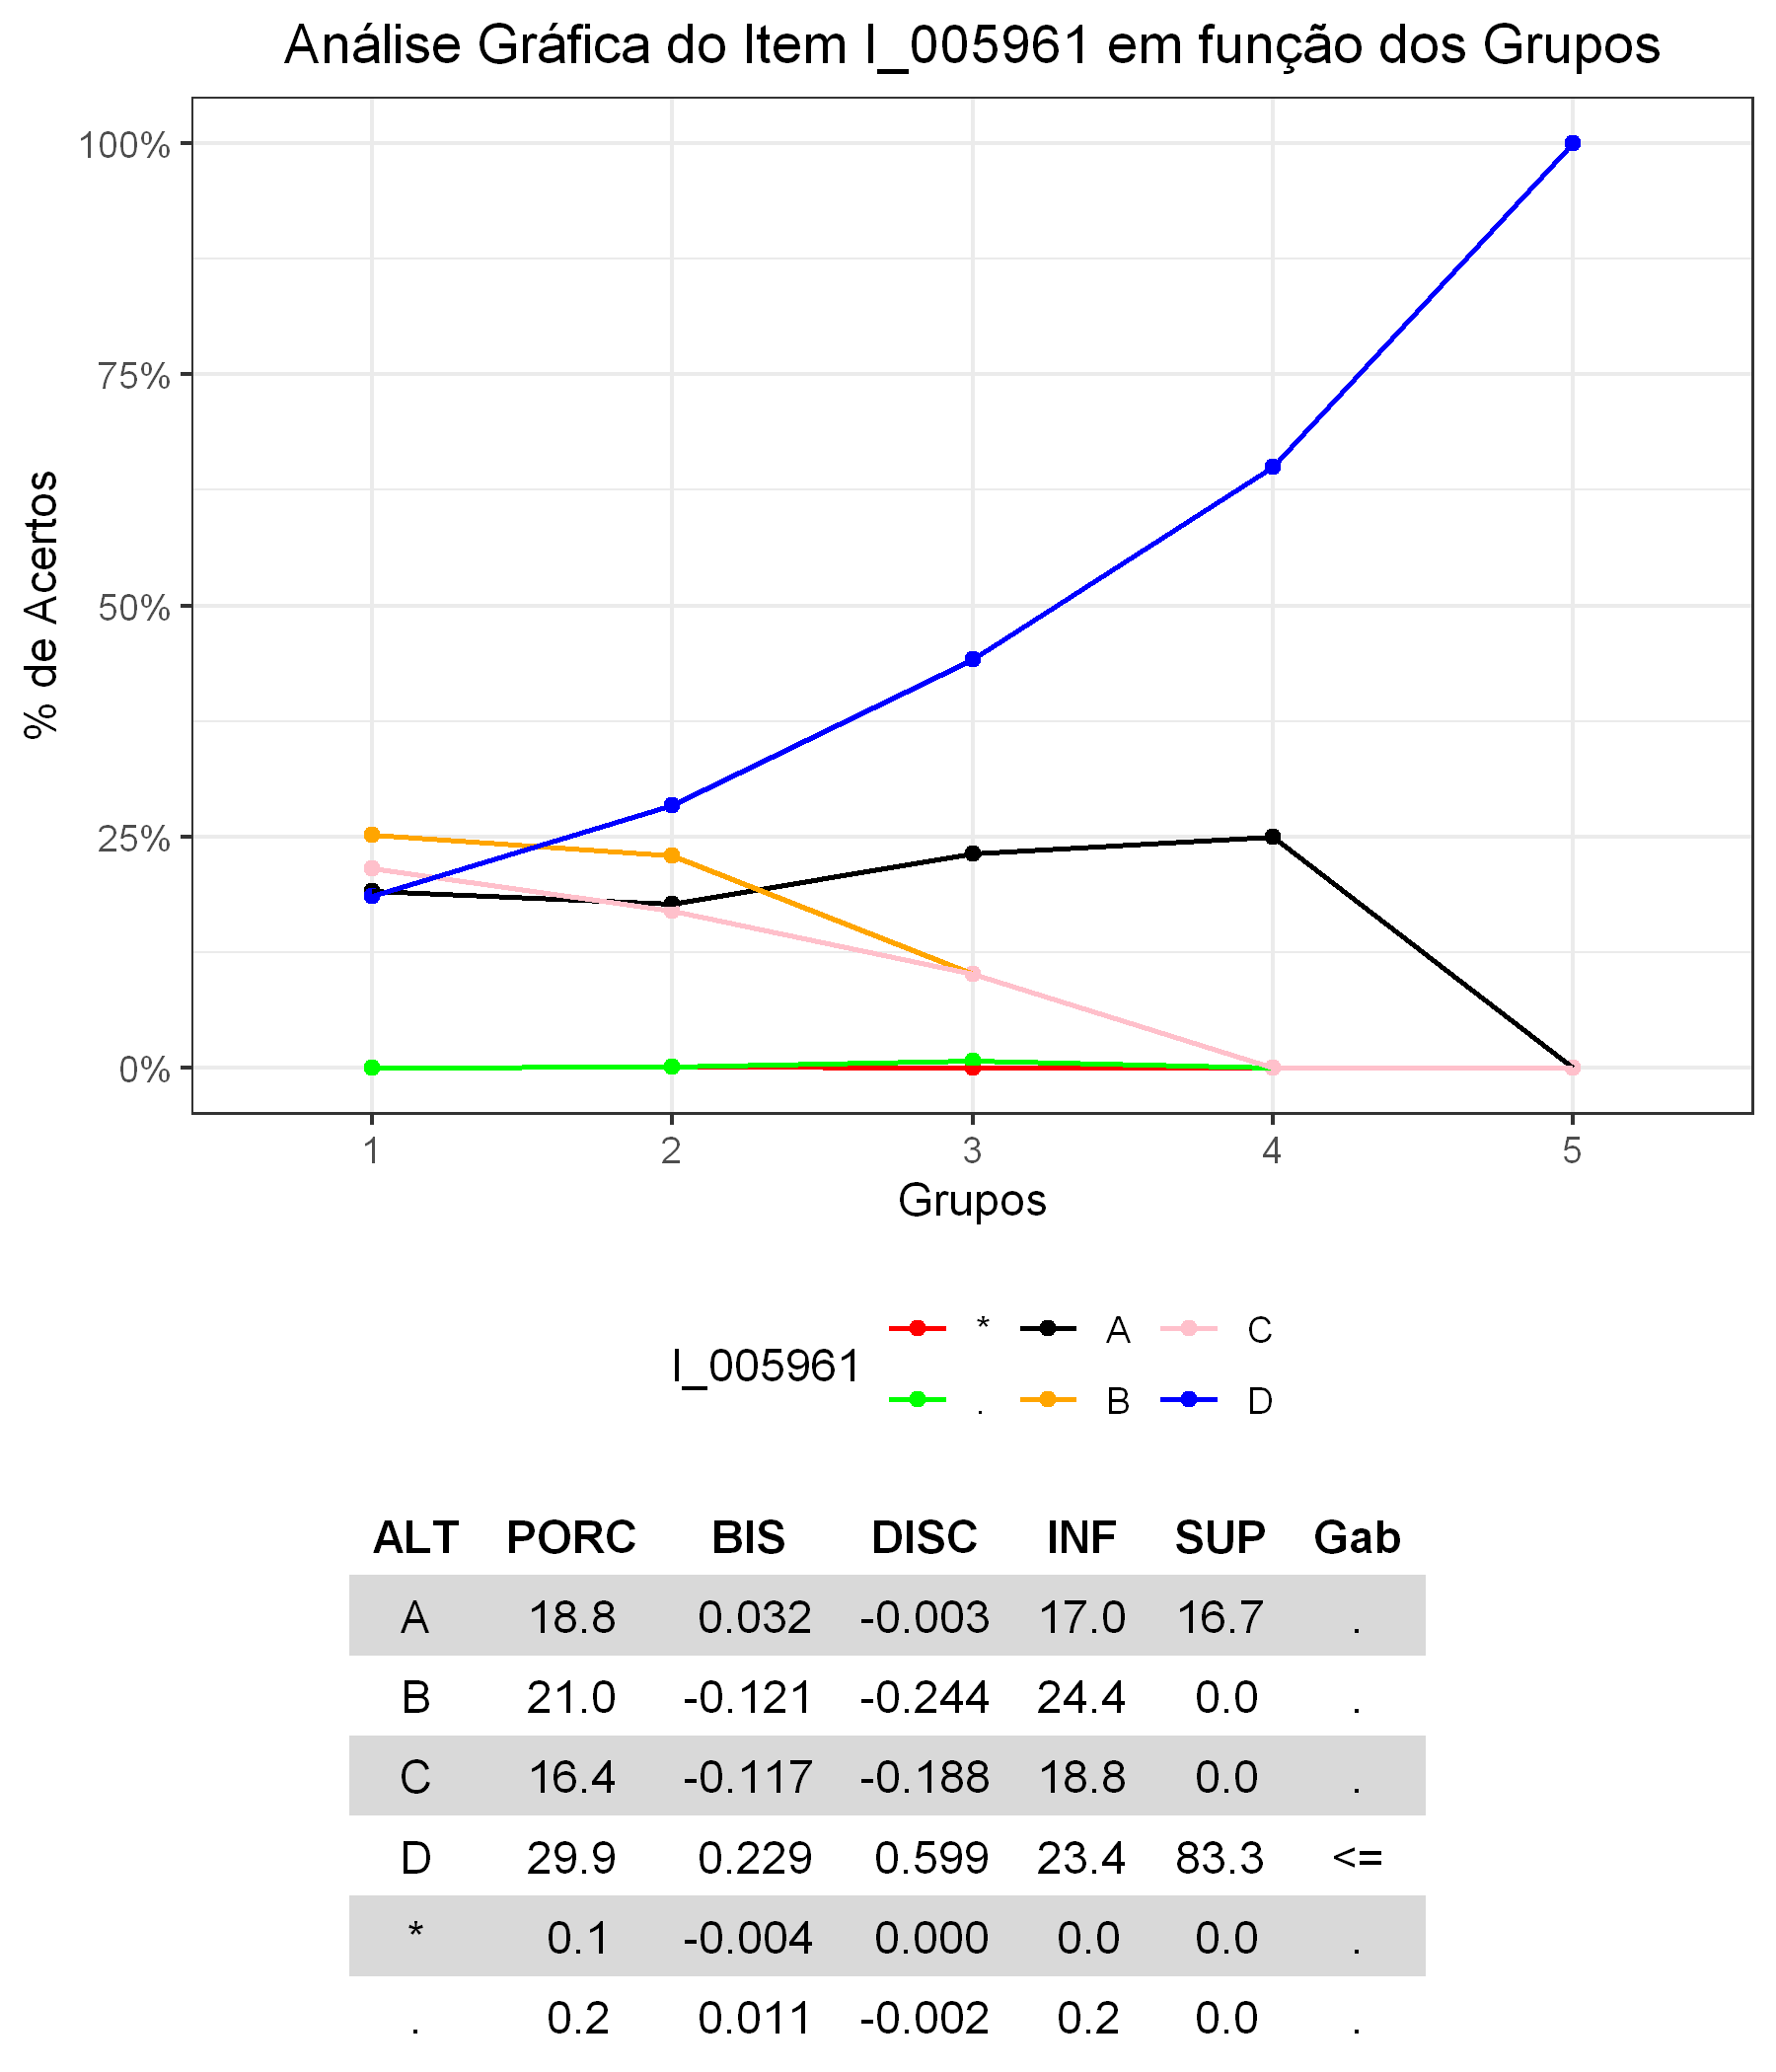

In [115]:
options(repr.plot.width = 6, repr.plot.height = 7, repr.plot.res = 300)
gera_tct("I_005961")

`summarise()` has grouped output by 'grupo'. You can override using the `.groups` argument.


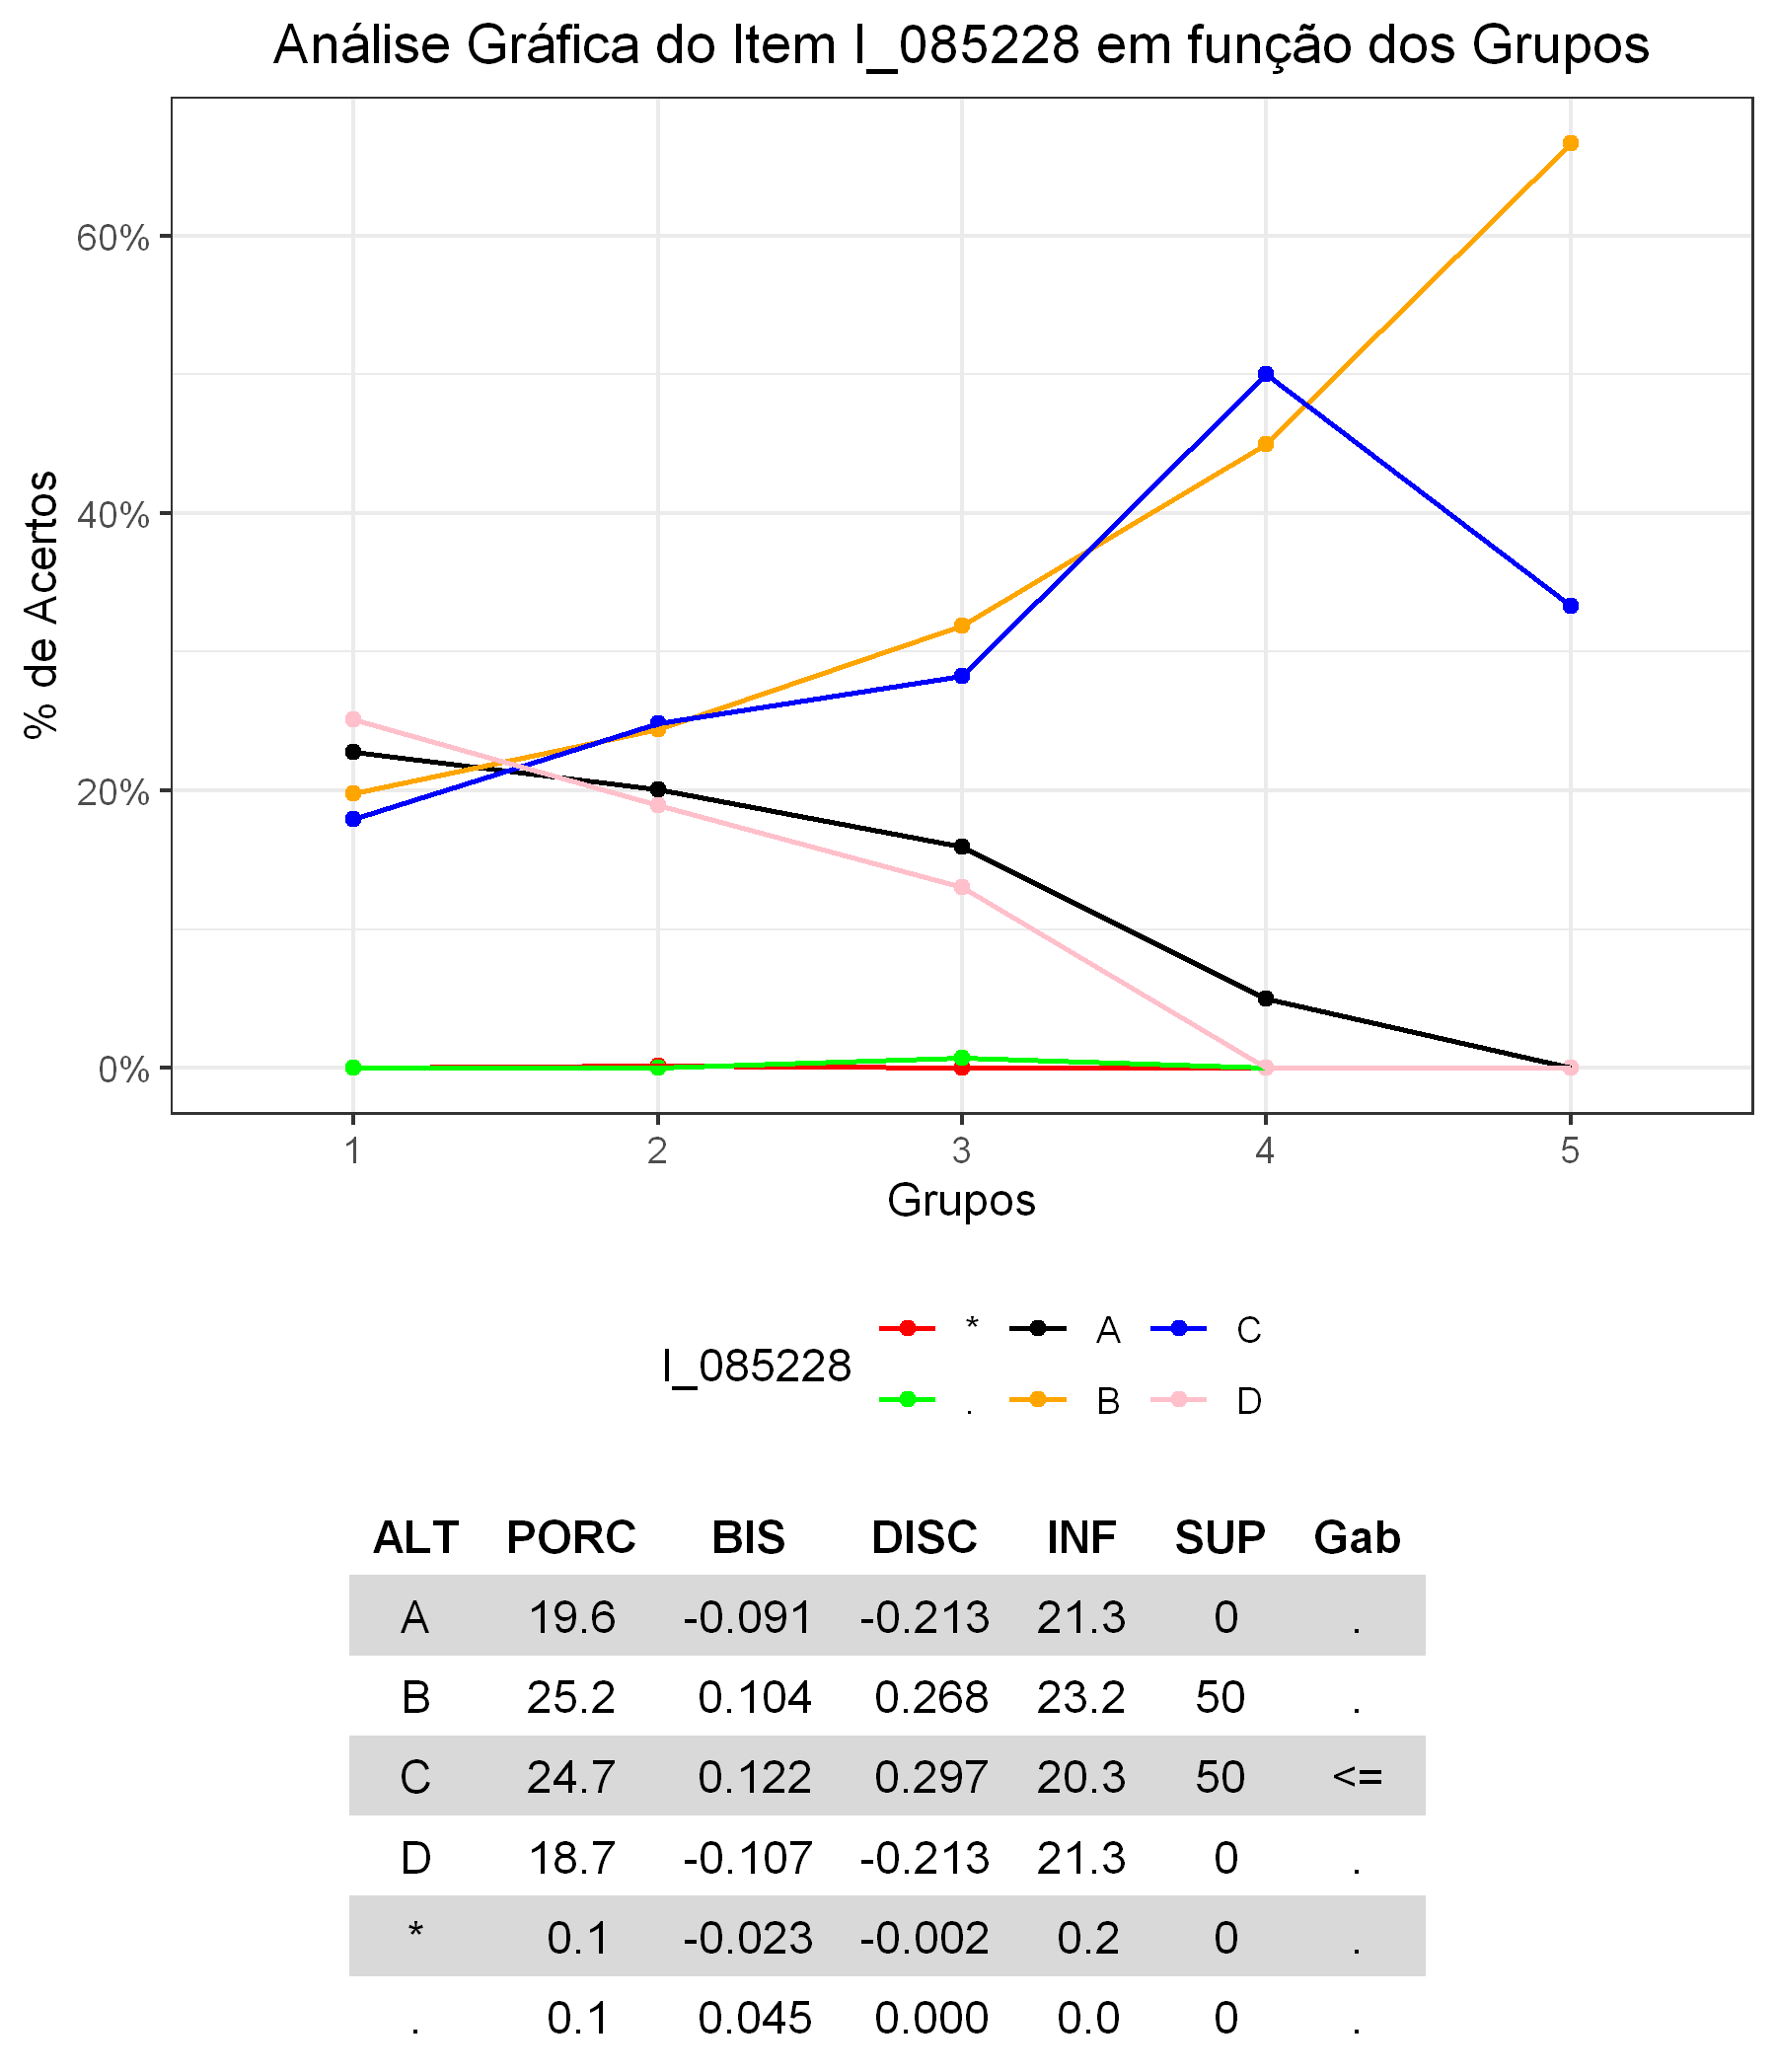

In [113]:
options(repr.plot.width = 6, repr.plot.height = 7, repr.plot.res = 300)
gera_tct("I_085228")



---
## Análise TRI



### Calibração de parâmetros de Itens


In [83]:
check_par_a <- function(a){
  a <- format(round(a,4), nsmall = 4)
  cell_spec(a,
            bold=ifelse(as.numeric(a) < 0.2 | as.numeric(a) > 6, T,F),
            color=ifelse(as.numeric(a) < 0.2 | as.numeric(a) > 6, "red","black"))
  
}
check_par_b <- function(b){
  b <- format(round(b,4), nsmall = 4)
  cell_spec(b,
            bold=ifelse(as.numeric(b) < -7 | as.numeric(b) > 7, T,F),
            color=ifelse(as.numeric(b) < -7 | as.numeric(b) > 7, "red","black"))
}
check_par_c <- function(c){
  c <- format(round(c,4), nsmall = 4)
  cell_spec(c,
            bold=ifelse(as.numeric(c) > 0.45, T,F),
            color=ifelse(as.numeric(c) > 0.45, "red","black"))
}

 #### Rodada 1

In [47]:
itens_rodada_1 <- colnames(dplyr::select(amostra_correcao_ordenada,-NU_INSCRICAO))

In [50]:
mod_rodada_1 <- mirt(dplyr::select(amostra_correcao_ordenada,all_of(itens_rodada_1)), 1, itemtype= '3PL', SE=T, technical = list(NCYCLES = 10000))

Iteration: 10000, Log-Lik: -23748.702, Max-Change: 0.00017

EM cycles terminated after 10000 iterations.





Calculating information matrix...


In [85]:
pars_mod_rodada_1 = coef(mod_rodada_1, IRTpars=TRUE, simplify=TRUE)$items[,1:3]

pars_mod_rodada_1 |> 
  data.frame() |> 
  rownames_to_column("Item") |>
  rename(Dificuldade = b,Discriminacao = a, Chute = g) |> 
  mutate(Dificuldade    = check_par_b(Dificuldade)) |> 
  mutate(Discriminacao  = check_par_a(Discriminacao)) |> 
  mutate(Chute          = check_par_c(Chute)) |> 
  kbl(linesep="", escape = F,row.names=F,align="c",digits = 4,longtable = T) |> 
  as.character() |>
  display_html()

Item,Discriminacao,Dificuldade,Chute
I_005961,1.6012,2.1539,0.2427
I_008364,1.4889,1.9363,0.2000
I_010322,1.7202,0.8676,0.3019
I_010409,0.7047,1.1496,0.0632
I_010500,1.7414,3.1875,0.1578
I_014797,6.7573,2.0230,0.1305
I_019807,7.7441,2.1146,0.0738
I_028683,4.2121,1.9634,0.2476
I_030053,2.9979,1.7429,0.2626
I_030327,1.8442,-0.1170,0.0077


 #### Rodada 2

In [69]:
itens_rodada_2 <- amostra_correcao_ordenada |> 
  dplyr::select(-NU_INSCRICAO, -I_086499, -I_089637, -I_117886) |> 
  colnames()

In [70]:
mod_rodada_2 <- mirt(dplyr::select(amostra_correcao_ordenada,all_of(itens_rodada_2)), 1, itemtype= '3PL', SE=T, technical = list(NCYCLES = 10000))

Iteration: 10000, Log-Lik: -22487.267, Max-Change: 0.00016

EM cycles terminated after 10000 iterations.





Calculating information matrix...


In [84]:
pars_mod_rodada_2 = coef(mod_rodada_2, IRTpars=TRUE, simplify=TRUE)$items[,1:3]

pars_mod_rodada_2 |> 
  data.frame() |> 
  rownames_to_column("Item") |>
  rename(Dificuldade = b,Discriminacao = a, Chute = g) |> 
  mutate(Dificuldade    = check_par_b(Dificuldade)) |> 
  mutate(Discriminacao  = check_par_a(Discriminacao)) |> 
  mutate(Chute          = check_par_c(Chute)) |> 
  kbl(linesep="", escape = F,row.names=F,align="c",digits = 4,longtable = T) |> 
  as.character() |>
  display_html()

Item,Discriminacao,Dificuldade,Chute
I_005961,1.6008,2.1548,0.2428
I_008364,1.4864,1.9358,0.1998
I_010322,1.7187,0.8677,0.3018
I_010409,0.6975,1.1289,0.0573
I_010500,1.7415,3.1884,0.1578
I_014797,6.7839,2.0227,0.1305
I_019807,7.7318,2.1143,0.0738
I_028683,4.1973,1.9632,0.2476
I_030053,2.9950,1.7433,0.2626
I_030327,1.8417,-0.1170,0.0078


 #### Rodada 3

In [86]:
itens_rodada_3 <- amostra_correcao_ordenada |> 
  dplyr::select(-NU_INSCRICAO, -I_086499, -I_089637, -I_117886, -I_014797, -I_019807, -I_085013, -I_085343, -I_086466, -I_086840, -I_117820) |> 
  colnames()

In [87]:
mod_rodada_3 <- mirt(dplyr::select(amostra_correcao_ordenada,all_of(itens_rodada_3)), 1, itemtype= '3PL', SE=T, technical = list(NCYCLES = 10000))

Iteration: 10000, Log-Lik: -19131.193, Max-Change: 0.00011

EM cycles terminated after 10000 iterations.





Calculating information matrix...


In [88]:
pars_mod_rodada_3 = coef(mod_rodada_3, IRTpars=TRUE, simplify=TRUE)$items[,1:3]

pars_mod_rodada_3 |> 
  data.frame() |> 
  rownames_to_column("Item") |>
  rename(Dificuldade = b,Discriminacao = a, Chute = g) |> 
  mutate(Dificuldade    = check_par_b(Dificuldade)) |> 
  mutate(Discriminacao  = check_par_a(Discriminacao)) |> 
  mutate(Chute          = check_par_c(Chute)) |> 
  kbl(linesep="", escape = F,row.names=F,align="c",digits = 4,longtable = T) |> 
  as.character() |>
  display_html()

Item,Discriminacao,Dificuldade,Chute
I_005961,1.3232,2.2555,0.2322
I_008364,1.3961,1.9681,0.1961
I_010322,1.8201,0.8800,0.3095
I_010409,0.6593,1.0470,0.0309
I_010500,1.9066,3.0677,0.1586
I_028683,5.1029,1.9405,0.2497
I_030053,2.9941,1.7440,0.2630
I_030327,1.8502,-0.1025,0.0167
I_030493,0.5194,2.5043,0.0940
I_031516,1.5570,1.6374,0.1720


 #### Rodada 4

In [89]:
itens_rodada_4 <- amostra_correcao_ordenada |> 
  dplyr::select(-NU_INSCRICAO, -I_086499, -I_089637, -I_117886, -I_014797, -I_019807, -I_085013, -I_085343, -I_086466, -I_086840, -I_117820, -I_053461) |> 
  colnames()

In [90]:
mod_rodada_4 <- mirt(dplyr::select(amostra_correcao_ordenada,all_of(itens_rodada_4)), 1, itemtype= '3PL', SE=T, technical = list(NCYCLES = 10000))

Iteration: 10000, Log-Lik: -18578.506, Max-Change: 0.00057

EM cycles terminated after 10000 iterations.





Calculating information matrix...


In [91]:
pars_mod_rodada_4 = coef(mod_rodada_4, IRTpars=TRUE, simplify=TRUE)$items[,1:3]

pars_mod_rodada_4 |> 
  data.frame() |> 
  rownames_to_column("Item") |>
  rename(Dificuldade = b,Discriminacao = a, Chute = g) |> 
  mutate(Dificuldade    = check_par_b(Dificuldade)) |> 
  mutate(Discriminacao  = check_par_a(Discriminacao)) |> 
  mutate(Chute          = check_par_c(Chute)) |> 
  kbl(linesep="", escape = F,row.names=F,align="c",digits = 4,longtable = T) |> 
  as.character() |>
  display_html()

Item,Discriminacao,Dificuldade,Chute
I_005961,1.3437,2.2451,0.2330
I_008364,1.4930,1.9333,0.2002
I_010322,1.8587,0.8883,0.3131
I_010409,0.6499,1.0244,0.0238
I_010500,2.2490,2.8345,0.1586
I_028683,3.9964,1.9632,0.2470
I_030053,3.1104,1.7382,0.2639
I_030327,1.8452,-0.1055,0.0149
I_030493,0.5340,2.5074,0.1006
I_031516,1.6241,1.6242,0.1751



### Estimação de Proficiências


In [101]:
proficiencia <-  fscores(mod_rodada_4, method = "EAP",response.pattern = dplyr::select(amostra_correcao_ordenada,all_of(itens_rodada_4))) 

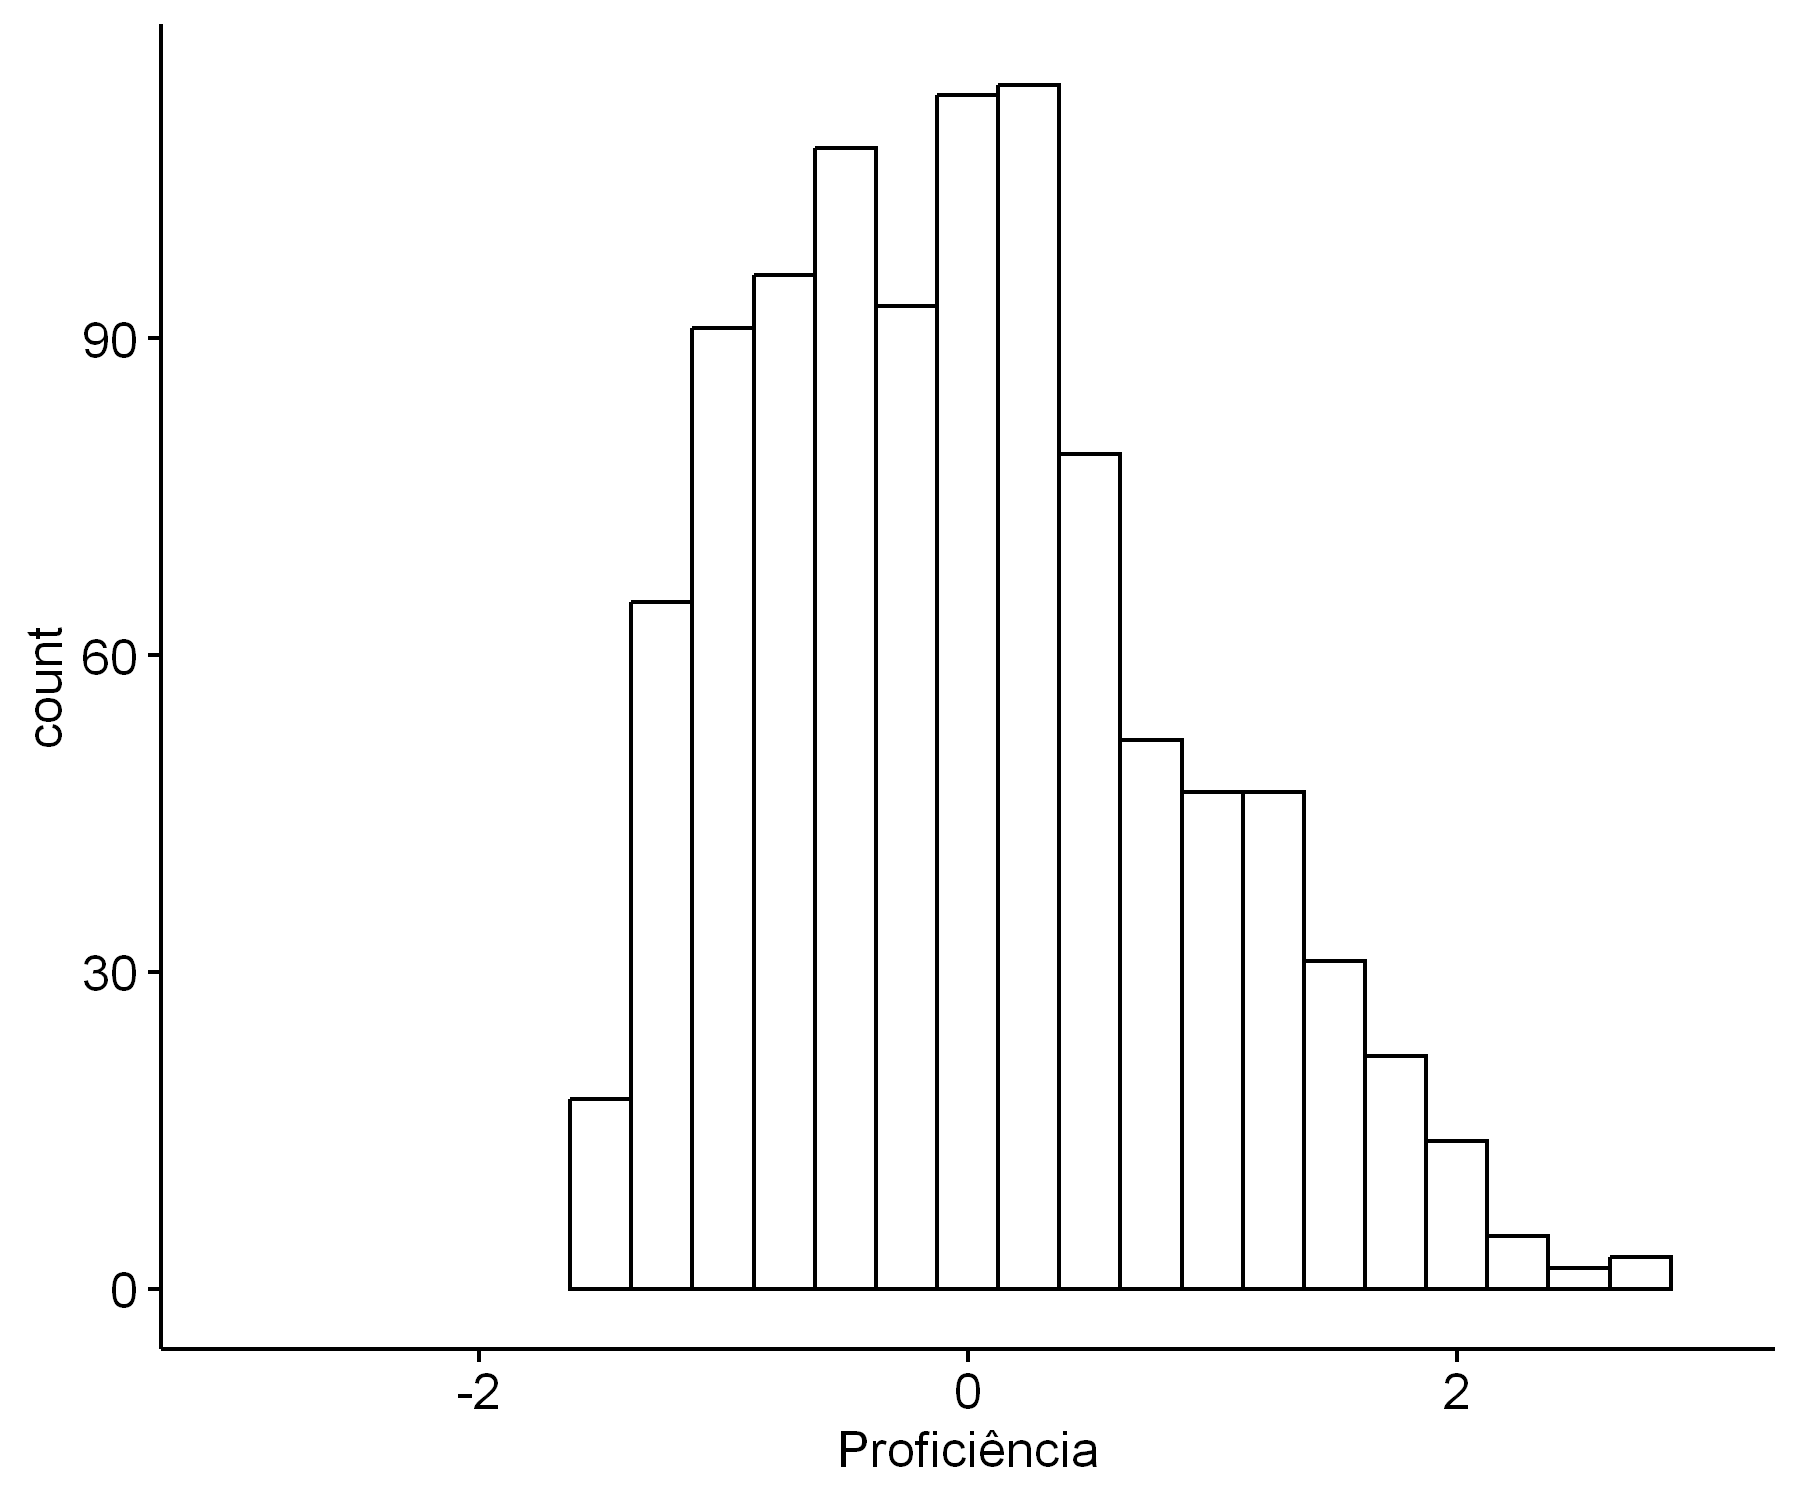

In [108]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300,repr.plot.scale=0.5)
gghistogram(proficiencia[,1],xlim=c(-3,3),binwidth = 0.25,xlab = "Proficiência")